### Evaluation of Variational Autoencoder (VAE) for KDD CUP

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import ML libraries
import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imbens.ensemble import SelfPacedEnsembleClassifier
from scikeras.wrappers import KerasClassifier
import keras_tuner
from keras import layers
from keras import ops
from keras import optimizers
import tensorflow as tf

from pprint import pprint
from time import time
import joblib

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

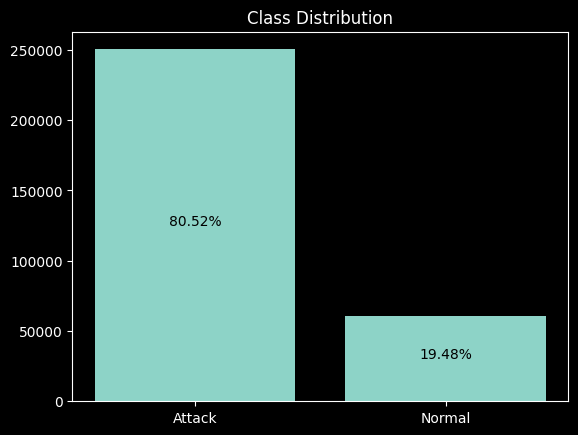

Weights:  {0: 4.991290198603437e-06, 1: 2.062961587655238e-05}
Transformed X_train shape: (200349, 117)


In [2]:
# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

## AE specific pre-processing: Only use negative samples for training
X_train = X_train[y_train == 0].copy()
neg_y_train = y_train[y_train == 0].copy()

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Set class weights
class_weight = {label[0]: 1.0 / count for label, count in df(y_train).value_counts().items()}
print("Weights: ", class_weight)

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=False
)
numeric_transformer.set_output(transform="pandas")

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=False,
)
categorical_transformer.set_output(transform="pandas")

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=False,
)


# Check preprocessing pipeline and get target shape
transformed_sample = preprocessor.fit_transform(X_train)
print(f"Transformed X_train shape: {transformed_sample.shape}")

### 2. Define models and parameters

In [3]:
# VAE Keras Custom Model Class. Implementation based on Bank et al (2021)
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, kl_beta=1, **kwargs):
        super().__init__(**kwargs)
        self.decoder = decoder
        self.encoder = encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.kl_beta = (
            kl_beta  # weight to put more or less balance on reconstruction loss
        )

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @tf.function
    def reconstruction_loss(self, x, f_z):
        # reconstruction_loss = keras.losses.binary_crossentropy(x, f_z)
        mse = keras.losses.MeanSquaredError()
        reconstruction_loss = mse(x, f_z)

        return reconstruction_loss

    @tf.function
    def loss_fn(self, x, f_z, z_mean, z_log_var):
        # Ensure reduction across the batch dimension
        reconstruction_loss = tf.reduce_mean(self.reconstruction_loss(x, f_z))

        # KL divergence calculation
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var + 1e-8), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # total loss calculation
        total_loss = reconstruction_loss + (self.kl_beta * kl_loss)
        return total_loss, reconstruction_loss, kl_loss

    @staticmethod  # Define the encoder model. See Bank et al (2021, p 8)
    def get_encoder(
        data_dim,
        latent_dim,
        hidden_dims,
        activation=keras.layers.ReLU(),
        dropout_rate=0,
    ):
        """Encoder Net

        Takes input x and maps it into a mean and covariance that determine the approximate posterior distribution of the latent space.

        Args:
            data_dim (_type_): Input dimension. Usually equal to n features.
            latent_dim (_type_): Size of the bottleneck.
            hidden_dims: List of hidden dims, e.g., [20, 10, 8]
            activtion: Activtion function for hidden dims

        Returns:
            z_mean: Mean
            z_log_var: Covariance
        """
        # Input Layer
        inputs = layers.Input(shape=(data_dim,))

        # Hidden Layer for compression
        x = inputs
        for dim in hidden_dims:
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)

        # calculate mean g(x) and covariance h(x) of the distribution
        z_mean = layers.Dense(latent_dim)(x)
        z_log_var = layers.Dense(latent_dim)(x)

        return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    @staticmethod  # Define the decoder model f(z)
    def get_decoder(
        latent_dim,
        output_dim,
        hidden_dims,
        activation=keras.layers.ReLU(),
        dropout_rate=0,
    ):
        # take sample from latent space as input
        latent_inputs = layers.Input(shape=(latent_dim,))

        # Hidden Layer for reconstruction
        x = latent_inputs
        for dim in reversed(hidden_dims):
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)

        # output reconstruction
        outputs = layers.Dense(output_dim, activation="sigmoid")(x)
        return keras.Model(latent_inputs, outputs, name="decoder")

    def sampling(
        self, args
    ):  # Define the sampling function. See Bank et al (2021, p 8)
        """Sample from latent space by applying 'Reparameterization'

        Args:
            args (list): List of mean and covariance (z_mean, z_log_var)

        Returns:
            z: Sample from the latent space
        """
        # unpack mean g(x) and covariance h(x)
        z_mean, z_log_var = args

        # epsilon is a normal distribution: N(0, I)
        epsilon = keras.random.normal(shape=tf.shape(z_mean), seed=self.seed_generator)

        # Sampling via reparametrisation trick: z = h(x)  * espilon + g(x)
        return epsilon * ops.exp(z_log_var * 0.5) + z_mean

    @tf.function
    def train_step(self, data):
        # data = random minibatch of M datapoints
        x = data

        with tf.GradientTape() as tape:
            # encode input to mean g(x) and covariance h(x)
            z_mean, z_log_var = self.encoder(x)

            # sample random z from latent space
            z = self.sampling((z_mean, z_log_var))

            # decode z via f(z)
            f_z = self.decoder(z)

            # calculate reconstruction loss
            loss, reconstruction_loss, kl_loss = self.loss_fn(x, f_z, z_mean, z_log_var)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_tracker.update_state(loss)

        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x)

        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)

        _, reconstruction_loss, _ = self.loss_fn(x, f_z, z_mean, z_log_var)
        return {
            "reconstruction_loss": reconstruction_loss,
        }

    def call(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x)

        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)

        return self.reconstruction_loss(x, f_z)


# Model builder for VAE
def _vae(
    data_dim=transformed_sample.shape[1],
    latent_dim=80,
    learning_rate=0.0000001,
    kl_beta=0.5,
    hidden_dims=[128, 128, 64],
    activation="relu",
    dropout_rate=0.0,
    optimizer="adam",
    cb_early_stopping_patience=15,
):
    print(
        f"Building VAE model with params: data_dim={data_dim}, latent_dim={latent_dim}, learning_rate={learning_rate}, kl_beta={kl_beta}, hidden_dims={hidden_dims}, activation={activation}, dropout_rate={dropout_rate}, optimizer={optimizer}, cb_early_stopping_patience={cb_early_stopping_patience}"
    )

    # Map activation string to Keras activation function
    if activation == "relu":
        activation_fn = keras.layers.ReLU()
    elif activation == "leaky_relu":
        activation_fn = keras.layers.LeakyReLU()
    else:
        raise ValueError(f"Unsupported activation function {activation}")

    # Map optimizer string to Keras optimizer
    if optimizer == "adam":
        optimizer_fn = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer {optimizer}")

    # Map early stopping callback patience
    cb_early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_reconstruction_loss",
        mode="min",
        patience=cb_early_stopping_patience,
    )

    # Build the encoder and decoder
    encoder = VAE.get_encoder(
        data_dim=data_dim,
        latent_dim=latent_dim,
        hidden_dims=hidden_dims,
        activation=activation_fn,
        dropout_rate=dropout_rate,
    )

    decoder = VAE.get_decoder(
        latent_dim=latent_dim,
        output_dim=data_dim,
        hidden_dims=hidden_dims,
        activation=activation_fn,
        dropout_rate=dropout_rate,
    )

    # Initialize VAE model
    vae = VAE(encoder, decoder, kl_beta=kl_beta)
    vae.build((None, data_dim))  # None indicates that the batch size can vary
    vae.compile(optimizer=optimizer_fn)

    return vae


# Define VAE KerasClassifier
vae_clf = KerasClassifier(
    build_fn=_vae,
    random_state=RANDOM_STATE,
    data_dim=transformed_sample.shape[1],
    latent_dim=80,
    learning_rate=0.0000001,
    kl_beta=0.5,
    hidden_dims=[128, 128, 64],
    activation="relu",
    dropout_rate=0.0,
    optimizer="adam",
    cb_early_stopping_patience=15,
    batch_size=128,
    epochs=100,
    verbose=0,
)

# Define VAE pipeline
vae_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("vae", vae_clf),
    ]
)
print("VAE pipeline:")
display(vae_pipeline)

# Define pipelie for RandomSearchCV
vae_rs_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rs_tuned_vae", vae_clf),
    ]
)
print("RandomSearchCV MLP pipeline:")
display(vae_rs_pipeline)

# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Define parameter grid
parameter_grid = {
    "rs_tuned_vae__batch_size": [128, 256],
    "rs_tuned_vae__epochs": [50, 100],
    "rs_tuned_vae__learning_rate": [0.00001, 0.000001],
    "rs_tuned_vae__kl_beta": [0.5, 1],
    "rs_tuned_vae__hidden_dims": [[128, 128, 64], [256, 128, 64]],
    "rs_tuned_vae__activation": ["relu", "leaky_relu"],
    "rs_tuned_vae__dropout_rate": [0.0, 0.2],
    "rs_tuned_vae__optimizer": ["adam"],
    "rs_tuned_vae__cb_early_stopping_patience": [10, 15],
    "rs_tuned_vae__latent_dim": [80, 100, 120],
}

# Randomized search with k-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=vae_rs_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,  # Define the number of random samples to try
    scoring=scoring,
    refit="f1",  # Refit on F1 score after finding the best parameters
    cv=StratifiedKFold(n_splits=5),  # 5-fold cross-validation
    verbose=1,
    n_jobs=1, # 1 job to avoid conflicts with un-serializable objects and pickling
    random_state=RANDOM_STATE,
    error_score="raise",
)

VAE pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 6, 11, 20, 21])])),
                ('vae',
                 KerasClassifier(activation='relu', batch_size=128, build_fn=<function _vae at 0x3317e3920>, cb_early_stopping_patience=15, data_dim=117, dropout_rate=0.0, epochs=100, hidden_dims=[128, 128, 64], kl_beta=0.5, latent_dim=80, learning_rate=1e-07, optimizer='adam', random_state=42, verbose=0))])

RandomSearchCV MLP pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 6, 11, 20, 21])])),
                ('rs_tuned_vae',
                 KerasClassifier(activation='relu', batch_size=128, build_fn=<function _vae at 0x3317e3920>, cb_early_stopping_patience=15, data_dim=117, dropout_rate=0.0, epochs=100, hidden_dims=[128, 128, 64], kl_beta=0.5, latent_dim=80, learning_rate=1e-07, optimizer='adam', random_state=42, verbose=0))])

In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin

class VAESklearnEstimator(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        data_dim,
        latent_dim=80,
        learning_rate=1e-6,
        kl_beta=0.5,
        hidden_dims=[128, 128, 64],
        activation='relu',
        dropout_rate=0.0,
        optimizer='adam',
        cb_early_stopping_patience=15,
        batch_size=128,
        epochs=100,
        verbose=0,
        random_state=None,
    ):
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.kl_beta = kl_beta
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.cb_early_stopping_patience = cb_early_stopping_patience
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None

    def _build_model(self):
        # Map activation function
        if self.activation == 'relu':
            activation_fn = keras.layers.ReLU()
        elif self.activation == 'leaky_relu':
            activation_fn = keras.layers.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")

        # Map optimizer
        if self.optimizer == 'adam':
            optimizer_fn = keras.optimizers.Adam(learning_rate=self.learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

        # Build the encoder and decoder
        encoder = VAE.get_encoder(
            data_dim=self.data_dim,
            latent_dim=self.latent_dim,
            hidden_dims=self.hidden_dims,
            activation=activation_fn,
            dropout_rate=self.dropout_rate,
        )

        decoder = VAE.get_decoder(
            latent_dim=self.latent_dim,
            output_dim=self.data_dim,
            hidden_dims=self.hidden_dims,
            activation=activation_fn,
            dropout_rate=self.dropout_rate,
        )

        # Initialize VAE model
        vae = VAE(encoder, decoder, kl_beta=self.kl_beta)
        vae.compile(optimizer=optimizer_fn)
        return vae

    def fit(self, X, y=None, **fit_params):
        # Set random seed
        if self.random_state is not None:
            tf.keras.utils.set_random_seed(self.random_state)

        # Convert data to appropriate format
        X = np.array(X)

        # Build the model
        self.model_ = self._build_model()

        # Extract validation data if provided
        validation_data = fit_params.get('validation_data', None)
        if validation_data is not None:
            X_val, y_val = validation_data
            X_val = np.array(X_val)
        else:
            X_val = None

        # Define callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=self.cb_early_stopping_patience,
                restore_best_weights=True,
            )
        ]

        # Fit the model
        self.model_.fit(
            X,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=callbacks,
            verbose=self.verbose,
            validation_data=(X_val, None) if X_val is not None else None,
        )
        return self

    def predict(self, X):
        X = np.array(X)

        # Use the call method to compute reconstruction loss
        reconstruction_loss = self.model_.call(X).numpy()
        # Determine threshold (you may need to adjust this)
        threshold = np.percentile(reconstruction_loss, 95)
        predictions = (reconstruction_loss > threshold).astype(int)
        return predictions

    def predict_proba(self, X):
        X = np.array(X)
        reconstruction_loss = self.model_.call(X).numpy()
        # Normalize reconstruction loss to [0,1]
        scores = (reconstruction_loss - reconstruction_loss.min()) / (reconstruction_loss.max() - reconstruction_loss.min())
        # Return probability estimates
        return np.vstack([1 - scores, scores]).T

    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

In [50]:
vae_estimator = VAESklearnEstimator(
    data_dim=transformed_sample.shape[1],
    latent_dim=80,
    learning_rate=1e-6,
    kl_beta=0.5,
    hidden_dims=[128, 128, 64],
    activation='relu',
    dropout_rate=0.0,
    optimizer='adam',
    cb_early_stopping_patience=15,
    batch_size=128,
    epochs=100,
    verbose=0,
    random_state=RANDOM_STATE,
)

vae_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("vae", vae_estimator),
    ]
)
display(vae_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
       'systat', 'telnet', 'tim_i', 'time', 'urp_i', 'uucp', 'uucp_path',
       'vmnet', 'whois'], dtype=object),
                                                                                             array(['OTH', 'REJ', 'RSTO', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'],
      dtype=object),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1])],
                                                                                 dtype='int8',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 6, 11, 20, 21])])),
                ('vae', VAESklearnEstimator(data_dim=117, random_state=42))])

In [53]:
# test run
vae_pipeline.fit(X_train, neg_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', 'auth', 'bgp', '...
       'systat', 'telnet', 'tim_i', 'time', 'urp_i', 'uucp', 'uucp_path',
       'vmnet', 'whois'], dtype=object),
                                                                                             array(['OTH', 'REJ', 'RSTO', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'],
      dtype=object),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1])],
                                                                                 dtype='int8',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [1, 2, 3, 6, 11, 20, 21])])),
                ('vae', VAESklearnEstimator(data_dim=117, random_state=42))])

In [54]:
# make predictions
# Predict labels
y_pred = vae_pipeline.predict(X_test)

# If you need probability estimates
y_proba = vae_pipeline.predict_proba(X_test)

print(classification_report(y_test, y_pred))

InvalidParameterError: The 'y_pred' parameter of classification_report must be an array-like or a sparse matrix. Got 0 instead.

In [46]:
# Define your scoring metrics
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Perform cross-validation
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for VAE:")
vae_scores = cross_validate(
    estimator=vae_pipeline,
    X=X_train,
    y=neg_y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring=scoring,
    n_jobs=1,
    verbose=2,
)

vae_scores_df = pd.DataFrame(vae_scores)

# Print mean ± standard deviation of scores
print("\nVAE Cross-Validation Results:")
for metric in scoring.keys():
    mean_score = vae_scores_df[f'test_{metric}'].mean()
    std_score = vae_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for VAE:
[CV] END .................................................... total time= 4.6min
[CV] END .................................................... total time= 4.6min
[CV] END .................................................... total time= 4.6min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.6min

VAE Cross-Validation Results:
f1: nan ± nan
precision: nan ± nan
recall: nan ± nan


### 3. Perform Cross-Validation on the training data

In [10]:
# Run random search on MLP and fit to training data
print("\nRunning RandomizedSearchCV for VAE...")
print("Hyperparameters to be evaluated:\n")
pprint(parameter_grid)

t0 = time()
random_search.fit(X_train, neg_y_train)
print(
    f"\RandomizedSearchCV took {time() - t0:.2f} seconds ({(time() - t0) / 60:.2f} minutes)"
)

print("\nBest parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Best estimator from RandomizedSearchCV
best_mlp_model = random_search.best_estimator_

# save best model
joblib.dump(best_mlp_model, f"./saved/{CKP_PREFIX}best_mlp_model.pkl")



Running RandomizedSearchCV for VAE...
Hyperparameters to be evaluated:

{'rs_tuned_vae__activation': ['relu', 'leaky_relu'],
 'rs_tuned_vae__batch_size': [128, 256],
 'rs_tuned_vae__cb_early_stopping_patience': [10, 15],
 'rs_tuned_vae__dropout_rate': [0.0, 0.2],
 'rs_tuned_vae__epochs': [50, 100],
 'rs_tuned_vae__hidden_dims': [[128, 128, 64], [256, 128, 64]],
 'rs_tuned_vae__kl_beta': [0.5, 1],
 'rs_tuned_vae__latent_dim': [80, 100, 120],
 'rs_tuned_vae__learning_rate': [1e-05, 1e-06],
 'rs_tuned_vae__optimizer': ['adam']}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Building VAE model with params: data_dim=117, latent_dim=100, learning_rate=1e-05, kl_beta=1, hidden_dims=[256, 128, 64], activation=leaky_relu, dropout_rate=0.2, optimizer=adam, cb_early_stopping_patience=10


ValueError: You must provide a loss or a compiled model

In [ ]:
# Get the index of the best combination found by RandomizedSearchCV
best_index = random_search.best_index_

# Extract mean and std for each metric from the best estimator
f1_mean = random_search.cv_results_['mean_test_f1'][best_index]
f1_std = random_search.cv_results_['std_test_f1'][best_index]

precision_mean = random_search.cv_results_['mean_test_precision'][best_index]
precision_std = random_search.cv_results_['std_test_precision'][best_index]

recall_mean = random_search.cv_results_['mean_test_recall'][best_index]
recall_std = random_search.cv_results_['std_test_recall'][best_index]

# Display results with mean ± std deviation format
print("\nRnadomSearchCV Cross-Validation Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")

# create pipeline
best_mlp_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("best_mlp", best_mlp_model['rs_tuned_mlp']),
])

In [16]:
display(_vae())

Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, dropout_rate=0.0, optimizer=adam, cb_early_stopping_patience=15


<VAE name=vae_11, built=True>

In [14]:
# 5-fold cross-validation for VAE Normal
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for VAE Normal:")

vae_scores = cross_validate(
    vae_pipeline, X_train, neg_y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=1, # 1 job to avoid conflicts with un-serializable objects and pickling
)
vae_scores_df = pd.DataFrame(vae_scores)

# Print mean ± standard deviation of scores
print("\nVAE Normal Cross-Validation Results:")
for metric in scoring.keys():
    mean_score = vae_scores_df[f'test_{metric}'].mean()
    std_score = vae_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for VAE Normal:
Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, dropout_rate=0.0, optimizer=adam, cb_early_stopping_patience=15
Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, dropout_rate=0.0, optimizer=adam, cb_early_stopping_patience=15
Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, dropout_rate=0.0, optimizer=adam, cb_early_stopping_patience=15
Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, dropout_rate=0.0, optimizer=adam, cb_early_stopping_patience=15
Building VAE model with params: data_dim=117, latent_dim=80, learning_rate=1e-07, kl_beta=0.5, hidden_dims=[128, 128, 64], activation=relu, drop

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py", line 928, in _fit
    self._ensure_compiled_model()
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/scikeras/wrappers.py", line 446, in _ensure_compiled_model
    raise ValueError("You must provide a loss or a compiled model")
ValueError: You must provide a loss or a compiled model


In [ ]:
# RandomSearch tuned MLP reports better results than the MLP architure used in the creditcard notebook
# So we will use the best model from RandomSearchCV for RandomOverSampler and SelfPacedEnsembleClassifier

# Define RandOver pipeline
import copy


mlp_randover_pipeline = imblearn_pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "ros",
            RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy=1),
        ),  # This will handle oversampling
        ("randover_mlp", best_mlp_model['rs_tuned_mlp']),
    ]
)
mlp_randover_pipeline.set_output(transform="pandas")

display(mlp_randover_pipeline)

# Define SPE pipeline
mlp_spe_pipeline = imblearn_pipeline(
    steps = [
		("preprocessor", preprocessor),
        (
            "spe_mlp",
            SelfPacedEnsembleClassifier(
                random_state=RANDOM_STATE, estimator=best_mlp_model['rs_tuned_mlp']
            ),
        ),
    ]
)
mlp_spe_pipeline.set_output(transform="pandas")
display(mlp_spe_pipeline)


In [ ]:
# 5-fold cross-validation for Random Oversampling
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Random Oversampling:")
ros_mlp_scores = cross_validate(
    mlp_randover_pipeline, pd.DataFrame(X_train, columns=col_names), y_train,
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
ros_mlp_scores_df = pd.DataFrame(ros_mlp_scores)

print("\nRandom Oversampling:")
for metric in scoring.keys():
    mean_score = ros_mlp_scores_df[f'test_{metric}'].mean()
    std_score = ros_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

In [ ]:
# 5-fold cross-validation for Self-Paced Ensemble
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Self-Paced Ensemble:")
spe_mlp_scores = cross_validate(
    mlp_spe_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_mlp_scores_df = pd.DataFrame(spe_mlp_scores)

print("\nSelf-Paced Ensemble:")
for metric in scoring.keys():
    mean_score = spe_mlp_scores_df[f'test_{metric}'].mean()
    std_score = spe_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

### 4. (Re)Train the models on the training data

In [ ]:
best_mlp_model_pipeline

In [ ]:
# Retrain and time each model
# Placeholder dictionary for training times
training_times = {}

# Train MLP Normal (optional)
print("Training MLP Normal...")
start_time = time()
mlp_normal_pipeline.fit(X_train, y_train)
training_times['MLP Normal'] = time() - start_time

# Train best MLP model (from RandomSearchCV)
print("Training Best MLP (RandomSearchCV)...")
start_time = time()
best_mlp_model_pipeline.fit(X_train, y_train)
training_times['Best MLP (RandomSearchCV)'] = time() - start_time

# Train SPE MLP
print("Training SPE MLP...")
start_time = time()
mlp_spe_pipeline.fit(X_train, y_train)
training_times['SPE MLP'] = time() - start_time

# Train Random Oversampling MLP
print("Training Random Oversampling MLP...")
start_time = time()
mlp_randover_pipeline.fit(X_train, y_train)
training_times['Random Oversampling MLP'] = time() - start_time

# Report training times
print("Training Times for Each Model (in seconds):")
for model_name, training_time in training_times.items():
    print(f"{model_name}: {training_time:.2f} seconds")

# save all models
joblib.dump(mlp_normal_pipeline, f"./saved/{CKP_PREFIX}mlp_normal_pipeline.pkl")
joblib.dump(mlp_spe_pipeline, f"./saved/{CKP_PREFIX}mlp_spe_pipeline.pkl")
joblib.dump(mlp_randover_pipeline, f"./saved/{CKP_PREFIX}mlp_randover_pipeline.pkl")
joblib.dump(best_mlp_model_pipeline, f"./saved/{CKP_PREFIX}best_mlp_model_pipeline.pkl")

### 5. Final evaluation of the models

In [ ]:
# evaluate each model on test set on f1, prec, recall and plot confusion matrix for each

# MLP Normal
y_test_pred = mlp_normal_pipeline.predict(X_test)
print("\nMLP Normal")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Best MLP model (RandomSearchCV)
y_test_pred = best_mlp_model_pipeline.predict(X_test)
print("\nBest MLP Model (RandomSearchCV)")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE MLP
y_test_pred = mlp_spe_pipeline.predict(X_test)
print("\nSPE MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Random Oversampling MLP
y_test_pred = mlp_randover_pipeline.predict(X_test)
print("\nRandOver MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([mlp_normal_pipeline, best_mlp_model_pipeline, mlp_spe_pipeline, mlp_randover_pipeline]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[1][0])
plt.show()
